In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')


%cd /content/gdrive/My Drive/hackathons/digital center/хакатон/
%ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1EMMRWEB_9gCSmnaLRszJOWMg0gcogEsh/hackathon/digital center/хакатон
 chunks.pkl                 fishnet_1.json    ldl.csv
 coords_ind.pkl             fishnet.json      Untitled0.ipynb
 coords_infected.csv        frames.pkl        геоданые/
'data_explore_1 AV.ipynb'   inf_squares.pkl  'Копия Untitled0.ipynb'


In [ ]:
pip install fiona

     |████████████████████████████████| 14.8MB 254kB/s 


In [ ]:
pip install PyCRS

  Created wheel for PyCRS: filename=PyCRS-1.0.2-cp36-none-any.whl size=32683 sha256=72d1816451a6916370212eab0eae4a0cf56d2c0ab06b0747aeccdd132de578f4
  Stored in directory: /root/.cache/pip/wheels/1a/c9/56/648f762bd41fdb03454be51b8a7069795925168833cb61f316
Successfully built PyCRS


In [ ]:
pip install pyshp

     |████████████████████████████████| 225kB 4.4MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.2-cp36-none-any.whl size=36216 sha256=0c36d69ae20ab0813e9753d95244416f620f71eaa1e0e8b4ea449d9b4f57d9a4
  Stored in directory: /root/.cache/pip/wheels/96/6c/53/4112475adf3b831da97f083163d0f38ee6daac9c1b13f7afea
Successfully built pyshp


In [2]:
import pandas as pd
import numpy as np
import os
import shapefile
import fiona
from tqdm import tqdm_notebook

In [ ]:
epidemic_spread = pd.read_excel('./геоданые/распространение заболевания. generated.xlsx')
date_time = epidemic_spread['date'].str.split('T',expand=True).rename(columns = {0:'Date',1:'Time'})
epidemic_spread = epidemic_spread.join(date_time).drop('date',1)

In [ ]:
adress = [string.lower() for string in tqdm_notebook(epidemic_spread['address'])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [ ]:
epidemic_spread['address'] = adress

# чистка данных

In [ ]:
delete = ['Город','город','Московская','московская','Область','область','Строение','строение',',','.']
corp = ['Корпус','корпус','Строение','строение']

In [ ]:
def clean_adress(df,column,corp):
  strings = []
  for string in tqdm_notebook(df[column]):
    
    for i in delete:
      string = string.replace(i,'')
    for j in corp:
      string = string.partition(j)[0]
    strings.append(string)

  return strings

In [ ]:

adtress = clean_adress(epidemic_spread,'address',corp)
epidemic_spread['address'] = adtress

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
list_adress = list(set(epidemic_spread['address']))

In [108]:
aipril = pd.read_csv('./геоданые/20200820/мар-апр 2019/02_CDensity_1_201904.csv.gz',nrows=100, compression='gzip',
                   error_bad_lines=False,sep=';')

In [ ]:
epidemic_spread = epidemic_spread.join(date_time).drop('date',1)

# считываем данные

In [ ]:
setka = os.listdir('./геоданые/20200820/сетка/fishnet/')
files = []
for file in setka:
  files.append(shapefile.Reader('./геоданые/20200820/сетка/fishnet/' + file))

records = [y[:] for y in files[4].records()]
sd = pd.DataFrame(records)
sd = sd.rename(columns = {0:'zid',1:'square',2:'XZ'})
coord = [x.points for x in files[4].shapes()]
coord=pd.DataFrame(coord)
sd = sd.join(coord)
# aipril = pd.merge(aipril,sd,on='zid',how = 'left')

In [ ]:
sd.head()

,zid,square,XZ,0,1,2,3,4
0,72137,249834.0,427489.0,"(38.678917098098, 54.2908802292932)","(38.6790454134575, 54.2953718154324)","(38.686724069494, 54.2952965043335)","(38.6865949217892, 54.2908049310962)","(38.678917098098, 54.2908802292932)"
1,9759,249843.0,427928.0,"(38.5647888846116, 54.3323767905076)","(38.5649049568664, 54.3368685209228)","(38.572591644867, 54.3368004413154)","(38.5724747380337, 54.3323087231701)","(38.5647888846116, 54.3323767905076)"
2,118792,249834.0,428368.0,"(38.6890548087688, 54.376144215557)","(38.6891846311596, 54.3806357214293)","(38.6968791633808, 54.3805596843108)","(38.6967485014868, 54.3760681914997)","(38.6890548087688, 54.376144215557)"
3,33066,249729.0,439110.0,"(40.1409520652149, 55.4046324892176)","(40.1412515241051, 55.4091194251451)","(40.1491379315491, 55.4089487729351)","(40.1488375800719, 55.4044618649047)","(40.1409520652149, 55.4046324892176)"
4,59909,249897.0,439766.0,"(37.8516652258544, 55.437132605373)","(37.8517051632003, 55.44162420721)","(37.8596063352682, 55.4416012454183)","(37.8595655007634, 55.4371096474115)","(37.8516652258544, 55.437132605373)"


In [ ]:
pip install geopy

# Преобразуем адресса в координаты

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()


/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [ ]:
def coord_finding(df):
  coords = []
  for address in tqdm_notebook(df):
    
    try:
      location = geolocator.geocode(address)
      location.latitude
    except:
      coords.append(0)
    else:
      coords.append((location.latitude, location.longitude))
  return coords


# Отбираем в множестве 5 500 адресов, который покрывают 135 000 инфицированных кейсов

In [ ]:
cunks = list(epidemic_spread['address'].value_counts()[:5500].keys())

In [ ]:
res=coord_finding(cunks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_res = pd.DataFrame([cunks,res]).T.rename(columns = {0:'address',1:'coordinates'})

In [ ]:
epidemic_spreads = pd.merge(epidemic_spread,df_res,on = 'address',how='left')

In [ ]:
epidemic_spreads = epidemic_spreads.dropna()
epidemic_spreads.shape

(130873, 4)

In [ ]:
epidemic_spreads.head()

,address,Date,Time,coordinates
0,москва бульвар дмитрия донского дом 11,2020-05-14,16:20:34.516Z,"(55.5692818, 37.5769079)"
1,москва бульвар дмитрия донского дом 11,2020-05-29,17:38:43.570Z,"(55.5692818, 37.5769079)"
2,москва бульвар дмитрия донского дом 11,2020-05-18,10:14:42.992Z,"(55.5692818, 37.5769079)"
3,москва бульвар дмитрия донского дом 11,2020-06-01,13:15:32.918Z,"(55.5692818, 37.5769079)"
4,москва бульвар дмитрия донского дом 11,2020-06-21,10:46:46.946Z,"(55.5692818, 37.5769079)"


In [ ]:
epidemic_spreads = epidemic_spreads[epidemic_spreads['coordinates']!=0]

In [ ]:
epidemic_spreads.to_csv('coords_infected.csv',index=False)

In [ ]:
coor_infected = pd.read_csv('coords_infected.csv')

coord_trash = coor_infected.coordinates
coord_trash = coord_trash.str.replace('(', '')
coord_trash = coord_trash.str.replace(')', '')
coord_trash = coord_trash.str.split(pat=',', expand=True).astype('float')
coord_trash

coor_infected['longitude'] = coord_trash[1]
coor_infected['latitude'] = coord_trash[0]

In [ ]:
epidemic_spreads = pd.read_csv('coords_infected.csv')

,address,Date,Time,coordinates,longitude,latitude
0,москва бульвар дмитрия донского дом 11,2020-05-14,16:20:34.516Z,"(55.5692818, 37.5769079)",37.576908,55.569282
1,москва бульвар дмитрия донского дом 11,2020-05-29,17:38:43.570Z,"(55.5692818, 37.5769079)",37.576908,55.569282
2,москва бульвар дмитрия донского дом 11,2020-05-18,10:14:42.992Z,"(55.5692818, 37.5769079)",37.576908,55.569282
3,москва бульвар дмитрия донского дом 11,2020-06-01,13:15:32.918Z,"(55.5692818, 37.5769079)",37.576908,55.569282
4,москва бульвар дмитрия донского дом 11,2020-06-21,10:46:46.946Z,"(55.5692818, 37.5769079)",37.576908,55.569282
...,...,...,...,...,...,...
54869,москва верхняя красносельская улица дом 8,2020-05-26,10:59:11.948Z,"(55.7854628, 37.6595388)",37.659539,55.785463
54870,москва верхняя красносельская улица дом 8,2020-05-23,11:05:52.203Z,"(55.7854628, 37.6595388)",37.659539,55.785463
54871,москва верхняя красносельская улица дом 8,2020-05-26,11:15:28.879Z,"(55.7854628, 37.6595388)",37.659539,55.785463
54872,москва верхняя красносельская улица дом 8,2020-05-26,11:11:23.574Z,"(55.7854628, 37.6595388)",37.659539,55.785463


# Работа с разбитием координат рамок

In [ ]:
cd = coord.copy()
cd = cd.drop(4,1)
cd =cd.rename(columns={0:'one',1:'two',2:'three',3:'four'})
cd.head()

,one,two,three,four
0,"(38.678917098098, 54.2908802292932)","(38.6790454134575, 54.2953718154324)","(38.686724069494, 54.2952965043335)","(38.6865949217892, 54.2908049310962)"
1,"(38.5647888846116, 54.3323767905076)","(38.5649049568664, 54.3368685209228)","(38.572591644867, 54.3368004413154)","(38.5724747380337, 54.3323087231701)"
2,"(38.6890548087688, 54.376144215557)","(38.6891846311596, 54.3806357214293)","(38.6968791633808, 54.3805596843108)","(38.6967485014868, 54.3760681914997)"
3,"(40.1409520652149, 55.4046324892176)","(40.1412515241051, 55.4091194251451)","(40.1491379315491, 55.4089487729351)","(40.1488375800719, 55.4044618649047)"
4,"(37.8516652258544, 55.437132605373)","(37.8517051632003, 55.44162420721)","(37.8596063352682, 55.4416012454183)","(37.8595655007634, 55.4371096474115)"


In [ ]:
cols = cd.columns
for col in cols:
  print(col)
  df = pd.DataFrame(cd[col].tolist(), index=cd.index)
  df.columns = [str(x) + '_'+col for x in df.columns]
  cd = cd.drop(col,1).join(df)


one
two
three
four


# Выявление какой адресс попадает в какой квадрат

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


In [ ]:
epidemic_spreads = pd.read_csv('coords_infected.csv')
df = pd.DataFrame(epidemic_spreads['coordinates'].tolist(), index=epidemic_spreads.index)
epidemic_spreads = epidemic_spreads.drop('coordinates',1).join(df)

In [ ]:
points = np.array(coor_infected[['longitude','latitude']])
points_tuple = set([tuple(x) for x in points])

In [ ]:
cd_s= cd.sort_values('0_one')
points = np.array(epidemic_spreads[[1,0]])
points_tuple = set([tuple(x) for x in points])
thrashold = 0.0004
res = []
for point in tqdm_notebook(points_tuple):
  pols = []
  
  y = point[0]
  x = point[1]
  
  batch = cd_s[(cd_s['0_one']<y) & (cd_s['0_one']<=y+thrashold)]
  lons_vectors = np.array(batch[['0_one','0_two','0_three','0_four']])
  lats_vectors = np.array(batch[['1_one','1_two','1_three','1_four']])
  batch =np.array(batch)
  for lons_vect,lats_vect in zip(lons_vectors,lats_vectors):
    lons_lats_vect = np.column_stack((lons_vect,lats_vect)) # Reshape coordinates
    polygon = Polygon(lons_lats_vect) # create polygon
    point = Point(y,x) # create point
    pols.append(polygon.contains(point)) # check if polygon contains point
  true_ind =  np.where(np.array(pols) == True)[0]

  try:
     true_ind[0]
  except:
    res.append('0')
  else:
    res.append(batch[true_ind[0]])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [21]:
import pickle
def save_pkl(variable, name):
    name = name + '.pkl'
    output = open(name, 'wb')
    pickle.dump(variable, output)
    output.close()
# res = pd.read_pickle('coords_ind.pkl')

In [ ]:
extra_coord = pd.DataFrame([points_tuple,res]).T
extra_coord =extra_coord[extra_coord[1]!='0']

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [ ]:

df = pd.DataFrame(extra_coord[0].tolist(), index=extra_coord.index)
df.columns = ['longitude','latitude']
df1 = pd.DataFrame(extra_coord[1].tolist(), index= extra_coord.index)
df1.columns = ['0_one',	'1_one','0_two','1_two','0_three','1_three','0_four','1_four']
extra_coord= extra_coord.join(df)
extra_coord = extra_coord.join(df1).drop([0,1],1)

In [ ]:

coor_infected = pd.merge(coor_infected,extra_coord, on =['longitude','latitude'],how = 'left') 

In [ ]:
coor_infected.dropna()

,address,Date,Time,coordinates,longitude,latitude,0_one,1_one,0_two,1_two,0_three,1_three,0_four,1_four
0,москва бульвар дмитрия донского дом 11,2020-05-14,16:20:34.516Z,"(55.5692818, 37.5769079)",37.576908,55.569282,37.575399,55.567872,37.575407,55.572364,37.583335,55.572359,37.583325,55.567867
1,москва бульвар дмитрия донского дом 11,2020-05-29,17:38:43.570Z,"(55.5692818, 37.5769079)",37.576908,55.569282,37.575399,55.567872,37.575407,55.572364,37.583335,55.572359,37.583325,55.567867
2,москва бульвар дмитрия донского дом 11,2020-05-18,10:14:42.992Z,"(55.5692818, 37.5769079)",37.576908,55.569282,37.575399,55.567872,37.575407,55.572364,37.583335,55.572359,37.583325,55.567867
3,москва бульвар дмитрия донского дом 11,2020-06-01,13:15:32.918Z,"(55.5692818, 37.5769079)",37.576908,55.569282,37.575399,55.567872,37.575407,55.572364,37.583335,55.572359,37.583325,55.567867
4,москва бульвар дмитрия донского дом 11,2020-06-21,10:46:46.946Z,"(55.5692818, 37.5769079)",37.576908,55.569282,37.575399,55.567872,37.575407,55.572364,37.583335,55.572359,37.583325,55.567867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54869,москва верхняя красносельская улица дом 8,2020-05-26,10:59:11.948Z,"(55.7854628, 37.6595388)",37.659539,55.785463,37.655518,55.783390,37.655536,55.787881,37.663507,55.787871,37.663488,55.783379
54870,москва верхняя красносельская улица дом 8,2020-05-23,11:05:52.203Z,"(55.7854628, 37.6595388)",37.659539,55.785463,37.655518,55.783390,37.655536,55.787881,37.663507,55.787871,37.663488,55.783379
54871,москва верхняя красносельская улица дом 8,2020-05-26,11:15:28.879Z,"(55.7854628, 37.6595388)",37.659539,55.785463,37.655518,55.783390,37.655536,55.787881,37.663507,55.787871,37.663488,55.783379
54872,москва верхняя красносельская улица дом 8,2020-05-26,11:11:23.574Z,"(55.7854628, 37.6595388)",37.659539,55.785463,37.655518,55.783390,37.655536,55.787881,37.663507,55.787871,37.663488,55.783379


# Выявление фреймов соседей

In [ ]:
sd = pd.DataFrame(records)
sd = sd.rename(columns = {0:'zid',1:'square',2:'XZ'})
coord = [x.points for x in files[4].shapes()]
coord=pd.DataFrame(coord)
sd = sd.join(coord)

In [ ]:
cd=sd[[0,1,2,3]]

In [ ]:
cd =cd.rename(columns={0:'one',1:'two',2:'three',3:'four'})
cols = cd.columns
for col in cols:
  print(col)
  df = pd.DataFrame(cd[col].tolist(), index=cd.index)
  df.columns = [str(x) + '_'+col for x in df.columns]
  cd = cd.drop(col,1).join(df)
sd = sd.join(cd).drop([0,1,2,3],1)

one
two
three
four


In [ ]:
ss = np.array(sd[['0_one','1_one','0_two','1_two','0_three','1_three','0_four','1_four']])
results = []
for s in tqdm_notebook(ss):
  ind = np.abs(s - ss).sum(axis=1)
  results.append(np.argwhere((ind<0.04) & (ind>0)).reshape(-1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
sd['neaighbours'] = results

In [71]:
save_pkl(sd,'frames')

In [70]:
sf = pd.read_pickle('frames.pkl')
sf.head()

,zid,square,XZ,4,0_one,1_one,0_two,1_two,0_three,1_three,0_four,1_four,neaighbours
0,72137,249834.0,427489.0,"(38.678917098098, 54.2908802292932)",38.678917,54.290880,38.679045,54.295372,38.686724,54.295297,38.686595,54.290805,"[56, 248, 449, 528, 608, 4439]"
1,9759,249843.0,427928.0,"(38.5647888846116, 54.3323767905076)",38.564789,54.332377,38.564905,54.336869,38.572592,54.336800,38.572475,54.332309,"[164, 329, 4782, 4929, 5200, 5345]"
2,118792,249834.0,428368.0,"(38.6890548087688, 54.376144215557)",38.689055,54.376144,38.689185,54.380636,38.696879,54.380560,38.696749,54.376068,"[28, 267, 460, 1184, 4801, 5169]"
3,33066,249729.0,439110.0,"(40.1409520652149, 55.4046324892176)",40.140952,55.404632,40.141252,55.409119,40.149138,55.408949,40.148838,55.404462,"[806, 4471, 4644, 5186, 98045, 188850]"
4,59909,249897.0,439766.0,"(37.8516652258544, 55.437132605373)",37.851665,55.437133,37.851705,55.441624,37.859606,55.441601,37.859566,55.437110,"[113, 582, 1984, 6230, 100390, 189878]"


# Модель v I

In [31]:
coor_infected = pd.read_pickle('inf_squares.pkl')

In [32]:
coor_infected['Date'] = pd.to_datetime(coor_infected['Date'])

In [51]:
coor_infected[(coor_infected['Date']=='2020-04-10') & (coor_infected['zid']==90626.0)].shape

(21, 15)

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

class SIR:
    def __init__(self, eons=7, Susceptible=950, Infected=50, Resistant=0, rateSI=0.05, rateIR=0.07):
        self.eons = eons
        self.Susceptible = Susceptible
        self.Infected = Infected
        self.Resistant = Resistant
        self.rateSI = rateSI
        self.rateIR = rateIR
        self.numIndividuals = Susceptible + Infected + Resistant
        self.results = None
        self.modelRun = False

    def run(self):
        Susceptible = [self.Susceptible]
        Infected = [self.Infected]
        Resistant = [self.Resistant]

        for step in range(1, self.eons):
            S_to_I = (self.rateSI * Susceptible[-1] * Infected[-1]) / self.numIndividuals
            I_to_R = Infected[-1] * self.rateIR
            Susceptible.append(Susceptible[-1] - S_to_I)
            Infected.append(Infected[-1] + S_to_I - I_to_R)
            Resistant.append(Resistant[-1] + I_to_R)

        self.results = pd.DataFrame.from_dict({'Time':list(range(len(Susceptible))),
            'Susceptible':Susceptible, 'Infected':Infected, 'Resistant':Resistant},
            orient='index').transpose()
        self.modelRun = True

        return self.results

In [20]:
chunksize = 1000000
chunks = []
for chunk in tqdm_notebook(pd.read_csv('./геоданые/20200820/мар-апр 2019/02_CDensity_1_201904.csv.gz',chunksize=chunksize,iterator = True, compression='gzip',
                   error_bad_lines=False,sep=';')):
    
  CHUNK = chunk.join(chunk['ts'].str.split(' ',expand=True).rename(columns = {0:'Date',1:'Time'}).drop(['Time'],1)).drop('ts',1).groupby(['Date','zid']).mean().reset_index()
  chunks.append(CHUNK[CHUNK['zid'].isin(a)])
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [124]:
density = pd.concat(chunks)

In [125]:
density = density.groupby(['Date','zid']).mean().reset_index()


In [126]:
density

,Date,zid,customers_cnt_total,customers_cnt_long,customers_cnt_work,customers_cnt_loc
0,04.01,52,3799.162500,3238.675000,355.500000,2760.925000
1,04.01,293,2960.265873,2567.238095,359.174603,2114.146825
2,04.01,771,3960.166667,3388.123016,547.448413,2797.099206
3,04.01,1030,3493.081197,2912.192308,745.029915,2122.213675
4,04.01,1163,1549.511905,1220.892857,471.369048,743.678571
...,...,...,...,...,...,...
20706,04.30,189278,4894.186047,4301.825581,697.197674,3635.337209
20707,04.30,189496,3487.754167,2761.762500,931.179167,1538.925000
20708,04.30,189645,2729.821429,2394.857143,233.845238,2211.750000
20709,04.30,189974,2640.304348,2186.934783,341.684783,2134.532609


# Prediction

In [127]:
prediction = pd.read_pickle('inf_squares.pkl').sort_values('Date')[:3000]

In [128]:
density['Date'] = ['2020-'+str(x).replace('.','-') for x in list(density['Date'])]

In [129]:
prediction = pd.merge(prediction, density[['zid','Date','customers_cnt_long']],on=['zid','Date'],how='left')
prediction = prediction.dropna()


In [130]:
zids = set(prediction['zid'])


In [213]:
predictions = []

for zid in zids:
  selected = prediction[prediction['zid']==zid].reset_index()['customers_cnt_long'][0]
  start_date = prediction[prediction['zid']==zid].reset_index()['Date'][0]
  preds = SIR(eons=9, Susceptible=selected, Infected=1, Resistant=0, rateSI=0.5, rateIR=0.01).run()
  dates = []
  for i in pd.date_range(date, periods=len(preds)):
    dates.append(i)
  preds['Time'] = dates
  preds['zid'] = zid
  predictions.append(preds)
  

In [209]:
save_pkl(predictions,'forecast_1')

In [165]:
a =prediction.groupby(['Date','zid']).mean().reset_index()

In [226]:
import matplotlib.pyplot as plt


In [214]:
Predictions = pd.concat(predictions)


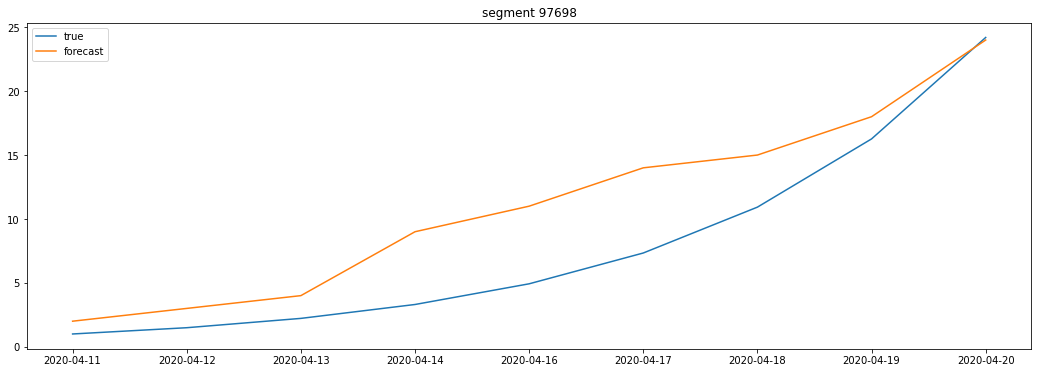

In [225]:
plt.figure(figsize=(18,6))
plt.title('segment 97698')
pred = Predictions[Predictions['zid'] ==97698]['Infected']
true = prediction[prediction['zid'] ==97698].groupby('Date').count().cumsum()['customers_cnt_long']
plt.plot(pred,label='true')
plt.plot(true,label='forecast')
plt.legend()


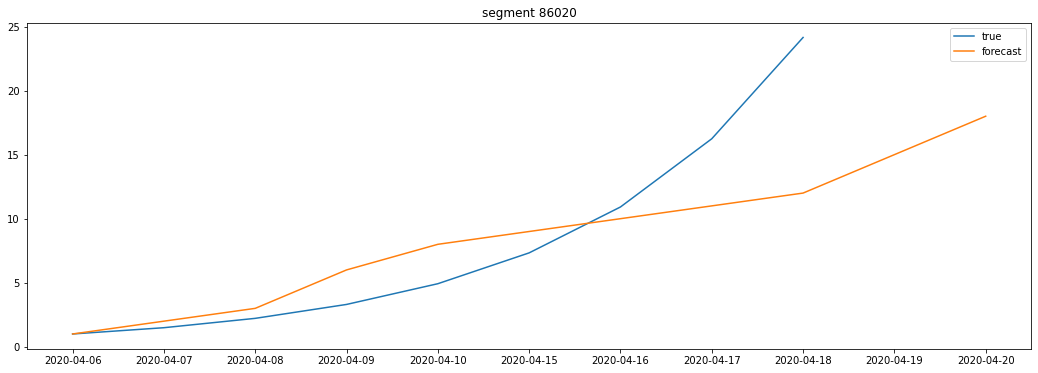

In [224]:
plt.figure(figsize=(18,6))
plt.title('segment 86020')
pred = Predictions[Predictions['zid'] ==86020]['Infected']
true = prediction[prediction['zid'] ==86020].groupby('Date').count().cumsum()['customers_cnt_long']
plt.plot(pred,label='true')
plt.plot(true,label='forecast')
plt.legend()